In [1]:
import os
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

import pandas as pd

from microsim.trials.trial_description import KaiserTrialDescription
from microsim.trials.trial_type import TrialType
from microsim.trials.trial import Trial
from microsim.trials.trial_outcome_assessor_factory import TrialOutcomeAssessorFactory
from microsim.treatment import TreatmentStrategiesType

from microsim.bp_treatment_strategies import SprintForLowerDbpGoalTreatment
from microsim.statin_treatment_strategies import StatinTreatmentStrategy
from microsim.treatment_strategy_repository import TreatmentStrategyRepository

pd.set_option('future.no_silent_downcasting', True) #make the calculation here future-proof

In [2]:
pd.set_option('future.no_silent_downcasting', True) #make the calculation here future-proof

In [3]:
ts = TreatmentStrategyRepository()
ts._repository[TreatmentStrategiesType.BP.value] = SprintForLowerDbpGoalTreatment()
ts._repository[TreatmentStrategiesType.STATIN.value] = StatinTreatmentStrategy()

In [4]:
pf=None
sampleSize = 300000
duration = 4
td = KaiserTrialDescription(trialType = TrialType.COMPLETELY_RANDOMIZED,
                            blockFactors=list(),
                            sampleSize = sampleSize, 
                            duration = duration, 
                            treatmentStrategies = ts,
                            nWorkers = 5, 
                            personFilters=pf)
td

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER

In [5]:
tr = Trial(td)
tr

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: False

In [6]:
tr.print_covariate_distributions()

                          self=treated, unique people count=  193408              other=control, unique people count=  193468  
                          self                                                    other
                          -----------------------------------------------------   -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd     min     0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------   -----------------------------------------------------
                    age    45.0    59.0    65.0    72.0   113.0    65.8     9.5    45.0    59.0    65.0    72.0   109.0    65.8     9.5
                    sbp    73.8   121.8   130.4   139.0   198.9   130.5    12.9    73.8   121.8   130.4   139.0   198.9   130.5    12.9
                    dbp    36.0    66.9    72.7    78.6   119.2    72.8     8.7    36.0    66.9    72.7  

In [7]:
from microsim.cv_model_repository import CVModelRepository
import numpy as np
def print_statin_treatment_opportunity(pop):
    popAlive = filter(lambda x: x.is_alive, pop._people)
    cvRiskList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), popAlive))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    statinList = list(map(lambda x: x._statin[-1], popAlive))
    
    binEdges = np.arange(0., 1.1, 0.1)
    binEdges[-1] += 0.0001
    
    cvRiskDigitized = np.digitize(cvRiskList, binEdges, right=False)

    risks = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
    popProportionList = list()
    statinProportionList = list()
    print(" "*25, "proportions")
    print(" "*15, "CV risk " + " "*3 + "with statin" + " "*2 + "of population")
    for i in np.arange(1, 11):
        
        statinForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, statinList))))
        meanStatin = np.mean(statinForGroupList)
        statinProportionList += [meanStatin]
        popProportion = len(statinForGroupList)/len(statinList)
        popProportionList += [popProportion]
        printString = f"{risks[i-1]:>23} "
        printString += f"{meanStatin:> 14.2f} "
        printString += f"{popProportion:> 14.2f} "
        print(printString)
        
    popAlive = filter(lambda x: x.is_alive, pop._people)
    sbpList = list(map(lambda x: x._sbp[-1], popAlive))
    print(" "*25, "sbp distribution")
    print(" "*15, "CV risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        sbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, sbpList))))
        rfList = sbpForGroupList
        rf = risks[i-1]
        if len(rfList)>0:
            print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    dbpList = list(map(lambda x: x._dbp[-1], popAlive))
    print(" "*25, "dbp distribution")
    print(" "*15, "CV risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        dbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, dbpList))))
        rfList = dbpForGroupList
        rf = risks[i-1]
        if len(rfList)>0:
            print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    ahcList = list(map(lambda x: x._antiHypertensiveCount[-1], popAlive))
    print(" "*25, "antiHypertensiveCount distribution")
    print(" "*15, "CV risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        ahcForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, ahcList))))
        rfList = ahcForGroupList
        rf = risks[i-1]
        if len(rfList)>0:
            print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    #####
        
    binEdges = np.arange(0., 1.1, 0.025)
    binEdges[-1] += 0.0001
    
    cvRiskDigitized = np.digitize(cvRiskList, binEdges, right=False)

    risks = ["0.025-0.0.05", "0.05-0.075", "0.075-0.1", "0.1-0.125", "0.125-0.15", "0.15-0.175", "0.175-0.2", "0.2-0.225", "0.225-0.25", "0.25-0.275"]
    print(" "*25, "proportions")
    print(" "*15, "CV risk " + " "*3 + "with statin" + " "*2 + "of population")
    for i in np.arange(1, 11):
        
        statinForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, statinList))))
        meanStatin = np.mean(statinForGroupList)
        printString = f"{risks[i-1]:>23} "
        printString += f"{meanStatin:> 14.2f} "
        printString += f"{len(statinForGroupList)/len(statinList):> 14.2f} "
        print(printString)  
        
    popAlive = filter(lambda x: x.is_alive, pop._people)
    sbpList = list(map(lambda x: x._sbp[-1], popAlive))
    print(" "*25, "sbp distribution")
    print(" "*15, "CV risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        sbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, sbpList))))
        rfList = sbpForGroupList
        rf = risks[i-1]
        print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    dbpList = list(map(lambda x: x._dbp[-1], popAlive))
    print(" "*25, "dbp distribution")
    print(" "*15, "CV risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        dbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, dbpList))))
        rfList = dbpForGroupList
        rf = risks[i-1]
        print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    ahcList = list(map(lambda x: x._antiHypertensiveCount[-1], popAlive))
    print(" "*25, "antiHypertensiveCount distribution")
    print(" "*15, "CV risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        ahcForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, ahcList))))
        rfList = ahcForGroupList
        rf = risks[i-1]
        print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")

def print_statin_treatment_opportunity_2(pop):
    popAlive = filter(lambda x: x.is_alive, pop._people)
    #cvRiskList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), popAlive))
    cvRiskComponentsList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_components_for_person(x, years=10),
                  popAlive))
    cvMinusScdRiskList = list(map(lambda x: x["riskMinusScd"], cvRiskComponentsList))
    cvScdRiskList = list(map(lambda x: x["riskScd"], cvRiskComponentsList))
    
    cvRiskList = cvMinusScdRiskList
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    statinList = list(map(lambda x: x._statin[-1], popAlive))
    
    binEdges = np.arange(0., 1.1, 0.1)
    binEdges[-1] += 0.0001
    
    cvRiskDigitized = np.digitize(cvRiskList, binEdges, right=False)

    risks = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
    popProportionList = list()
    statinProportionList = list()
    print(" "*25, "proportions")
    print(" "*10, "CV -SCD risk " + " "*3 + "with statin" + " "*2 + "of population")
    for i in np.arange(1, 11):
        
        statinForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, statinList))))
        meanStatin = np.mean(statinForGroupList)
        statinProportionList += [meanStatin]
        popProportion = len(statinForGroupList)/len(statinList)
        popProportionList += [popProportion]
        printString = f"{risks[i-1]:>23} "
        printString += f"{meanStatin:> 14.2f} "
        printString += f"{popProportion:> 14.2f} "
        print(printString)
        
    popAlive = filter(lambda x: x.is_alive, pop._people)
    sbpList = list(map(lambda x: x._sbp[-1], popAlive))
    print(" "*25, "sbp distribution")
    print(" "*10, "CV -SCD risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        sbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, sbpList))))
        rfList = sbpForGroupList
        rf = risks[i-1]
        if len(rfList)>0:
            print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    dbpList = list(map(lambda x: x._dbp[-1], popAlive))
    print(" "*25, "dbp distribution")
    print(" "*10, "CV -SCD risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        dbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, dbpList))))
        rfList = dbpForGroupList
        rf = risks[i-1]
        if len(rfList)>0:
            print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    ahcList = list(map(lambda x: x._antiHypertensiveCount[-1], popAlive))
    print(" "*25, "antiHypertensiveCount distribution")
    print(" "*10, "CV -SCD risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        ahcForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, ahcList))))
        rfList = ahcForGroupList
        rf = risks[i-1]
        if len(rfList)>0:
            print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    #####
        
    binEdges = np.arange(0., 1.1, 0.025)
    binEdges[-1] += 0.0001
    
    cvRiskDigitized = np.digitize(cvRiskList, binEdges, right=False)

    risks = ["0.025-0.0.05", "0.05-0.075", "0.075-0.1", "0.1-0.125", "0.125-0.15", "0.15-0.175", "0.175-0.2", "0.2-0.225", "0.225-0.25", "0.25-0.275"]
    print(" "*25, "proportions")
    print(" "*10, "CV -SCD risk " + " "*3 + "with statin" + " "*2 + "of population")
    for i in np.arange(1, 11):
        
        statinForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, statinList))))
        meanStatin = np.mean(statinForGroupList)
        printString = f"{risks[i-1]:>23} "
        printString += f"{meanStatin:> 14.2f} "
        printString += f"{len(statinForGroupList)/len(statinList):> 14.2f} "
        print(printString)  
        
    popAlive = filter(lambda x: x.is_alive, pop._people)
    sbpList = list(map(lambda x: x._sbp[-1], popAlive))
    print(" "*25, "sbp distribution")
    print(" "*10, "CV -SCD risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        sbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, sbpList))))
        rfList = sbpForGroupList
        rf = risks[i-1]
        print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    dbpList = list(map(lambda x: x._dbp[-1], popAlive))
    print(" "*25, "dbp distribution")
    print(" "*10, "CV -SCD risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        dbpForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, dbpList))))
        rfList = dbpForGroupList
        rf = risks[i-1]
        print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    ahcList = list(map(lambda x: x._antiHypertensiveCount[-1], popAlive))
    print(" "*25, "antiHypertensiveCount distribution")
    print(" "*10, "CV -SCD risk" + " "*0, "  min ", "  0.25", " "*1, "med", " "*2, "0.75", " "*2, "max", " "*1, "mean", " "*2, "sd")
    for i in np.arange(1, 11):
        ahcForGroupList = list(map(lambda x: int(x[1]), filter(lambda y: y[0]==i, zip(cvRiskDigitized, ahcList))))
        rfList = ahcForGroupList
        rf = risks[i-1]
        print(f"{rf:>23} {np.min(rfList):> 6.1f} {np.quantile(rfList, 0.25):> 6.1f} {np.quantile(rfList, 0.5):> 6.1f} {np.quantile(rfList, 0.75):> 6.1f} {np.max(rfList):> 6.1f} {np.mean(rfList):> 6.1f} {np.std(rfList):> 6.1f}")
    

In [8]:
#CV risk includes SCD component
print_statin_treatment_opportunity(tr.treatedPop)

                          proportions
                CV risk    with statin  of population
                0.0-0.1           0.29           0.36 
                0.1-0.2           0.47           0.23 
                0.2-0.3           0.54           0.13 
                0.3-0.4           0.57           0.07 
                0.4-0.5           0.58           0.05 
                0.5-0.6           0.58           0.04 
                0.6-0.7           0.60           0.03 
                0.7-0.8           0.61           0.03 
                0.8-0.9           0.56           0.02 
                0.9-1.0           0.57           0.03 
                          sbp distribution
                CV risk   min    0.25   med    0.75    max   mean    sd
                0.0-0.1   73.0  117.0  126.0  134.0  177.0  125.7   12.3
                0.1-0.2   81.0  122.0  131.0  139.0  191.0  130.6   12.2
                0.2-0.3   81.0  124.0  132.0  140.0  190.0  132.2   12.4
                0.3-0.4 

In [9]:
#CV risk does NOT include SCD component
print_statin_treatment_opportunity_2(tr.treatedPop)

                          proportions
           CV -SCD risk    with statin  of population
                0.0-0.1           0.37           0.67 
                0.1-0.2           0.58           0.23 
                0.2-0.3           0.64           0.07 
                0.3-0.4           0.62           0.02 
                0.4-0.5           0.58           0.01 
                0.5-0.6           0.53           0.00 
                0.6-0.7           0.44           0.00 
                0.7-0.8           0.13           0.00 
                0.8-0.9           0.50           0.00 
                0.9-1.0           0.64           0.00 
                          sbp distribution
           CV -SCD risk   min    0.25   med    0.75    max   mean    sd
                0.0-0.1   73.0  119.0  128.0  136.0  191.0  127.8   12.4
                0.1-0.2   78.0  125.0  133.0  142.0  194.0  133.3   12.5
                0.2-0.3   89.0  127.0  136.0  144.0  191.0  135.9   12.7
                0.3-0.4 

In [12]:
%%time
tr.run()
tr

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Trial is completed.
CPU times: user 4min 20s, sys: 6min 33s, total: 10min 54s
Wall time: 22min 20s


Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: True

In [13]:
tr.print_treatment_strategy_variables_distribution()

                          self=treated & alive, unique people count=  181213  
                          self
                          -----------------------------------------------------
                          proportions
                          -----------
            bpMedsAdded
                      0   0.52
                      1   0.18
                      2   0.16
                      3   0.10
                      4   0.03
           statinsAdded
                      0   0.29
                      1   0.71


In [14]:
toa = TrialOutcomeAssessorFactory.get_trial_outcome_assessor()
toa

Trial Outcome Assessor
	Assessments:
		Name: death                    Analysis: logistic       
		Name: anyEvent                 Analysis: logistic       
		Name: vascularEventOrDeath     Analysis: logistic       
		Name: vascularEvent            Analysis: logistic       
		Name: qalys                    Analysis: linear         
		Name: meanGCP                  Analysis: linear         
		Name: lastGCP                  Analysis: linear         
		Name: cogEvent                 Analysis: logistic       
		Name: deathCox                 Analysis: cox            
		Name: cogEventCox              Analysis: cox            
		Name: vascularEventOrDeathCox  Analysis: cox            
		Name: strokeRR                 Analysis: relativeRisk   
		Name: miRR                     Analysis: relativeRisk   
		Name: dementiaRR               Analysis: relativeRisk   
		Name: ciRR                     Analysis: relativeRisk   

In [15]:
tr.analyze(toa)
tr

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 4
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: True
Trial results:
	Analysis: linear
	                                         Z      Intercept           Z SE         pValue
	                    qalys:            0.02           3.62           0.00           0.00
	                  meanGCP:            0.12          52.10           0.02           0.00
	                  lastGCP:            0.13          50.51           0.02           0.00
	Analysis: logistic
	                                         Z      Intercept           Z SE         pValue
	                    death:           -0.08          -2.16           0.01           0.00
	                 anyEvent:           -0.06           0.88           0.01           0.00
	     vascularEventOrDeath:           -0.20          -1.62           0.01         

In [17]:
import numpy as np
from collections import Counter
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from microsim.cv_model_repository import CVModelRepository
from microsim.population import Population
import operator

In [18]:
def print_treatment_strategy_higher_order_information(pop):
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    ts = TreatmentStrategiesType.BP.value
    tsv = "bpMedsAdded"
    bpMedsAddedList = list(map(lambda x: x._treatmentStrategies[ts][tsv], popAlive))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    ts = TreatmentStrategiesType.STATIN.value
    tsv = "statinsAdded"
    statinsAddedList = list(map(lambda x: x._treatmentStrategies[ts][tsv], popAlive))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    antiHypertensiveCountPlusBPMedsAddedList = list(map(lambda x: x._antiHypertensiveCountPlusBPMedsAdded(), popAlive))
    ahcpbmaList = antiHypertensiveCountPlusBPMedsAddedList
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    statinList = list(map(lambda x: x._statin[-1], popAlive))
    
    statinPlusStatinsAddedList = list(map(operator.add, statinList, statinsAddedList))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    cvRiskComponentsList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_components_for_person(x, years=10),
                  popAlive))
    cvMinusScdRiskList = list(map(lambda x: x["riskMinusScd"], cvRiskComponentsList))
    cvScdRiskList = list(map(lambda x: x["riskScd"], cvRiskComponentsList))
    cvMinusScdRiskBoundaries = np.quantile(cvMinusScdRiskList, np.linspace(0, 1, 11))
    cvMinusScdRiskDeciles = np.digitize(cvMinusScdRiskList, cvMinusScdRiskBoundaries, right=False)
    cvMinusScdRiskDeciles[cvMinusScdRiskList == cvMinusScdRiskBoundaries[-1]] = 10
    
    #cvScdRiskCounts = Counter(cvScdRiskList)   
    #cvScdRiskBoundaries = np.quantile(cvScdRiskList, np.linspace(0, 1, 5))
    #cvScdRiskDeciles = np.digitize(cvScdRiskList, cvScdRiskBoundaries, right=False)
    #cvScdRiskDeciles[cvScdRiskList == cvScdRiskBoundaries[-1]] = 4
    print(" "*25, "self=treated & alive, unique people count= ",  f"{Population.get_unique_alive_people_count(pop._people):<8}")
    print(" "*25, "self")
    print(" "*25, "-"*53)
    print(" "*25, "min", " "*4, "0.25", " "*2, "med", " "*3, "0.75", " "*3, "max" , " "*2, "mean", " "*3, "sd")
    print(" "*25, "-"*53)
    print(" "*3, "CV - SCD risk decile  bpMedsAdded")
    for ile in sorted(set(cvMinusScdRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvMinusScdRiskDeciles, bpMedsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    cvRiskList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), popAlive))
    cvRiskBoundaries = np.quantile(cvRiskList, np.linspace(0, 1, 11))
    cvRiskDeciles = np.digitize(cvRiskList, cvRiskBoundaries, right=False)
    cvRiskDeciles[cvRiskList == cvRiskBoundaries[-1]] = 10
    print(" "*9, "CV risk decile  bpMedsAdded")
    for ile in sorted(set(cvRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvRiskDeciles, bpMedsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    #print(" "*12, "CV Scd risk  bpMedsAdded")
    #for key in sorted(cvScdRiskCounts.keys()):   
    #for ile in sorted(set(cvScdRiskDeciles)):
        #medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==key, zip(cvScdRiskList, bpMedsAddedList))))
        #print(f"{key:>23.3f} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    print(" "*3, "CV - SCD risk decile  antiHypertensiveCountPlusBpMedsAdded")
    for ile in sorted(set(cvMinusScdRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvMinusScdRiskDeciles, ahcpbmaList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    print(" "*9, "CV risk decile  antiHypertensiveCountPlusBpMedsAdded")
    for ile in sorted(set(cvRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvRiskDeciles, ahcpbmaList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    print(" "*3, "CV - SCD risk decile  statinsAdded")
    for ile in sorted(set(cvMinusScdRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvMinusScdRiskDeciles, statinsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    print(" "*9, "CV risk decile  statinsAdded")
    for ile in sorted(set(cvRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvRiskDeciles, statinsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    print(" "*3, "CV - SCD risk decile  statinPlusStatinsAdded")
    for ile in sorted(set(cvMinusScdRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvMinusScdRiskDeciles, statinPlusStatinsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    print(" "*9, "CV risk decile  statinPlusStatinsAdded")
    for ile in sorted(set(cvRiskDeciles)):
        medsList = list(map(lambda x: x[1], filter(lambda y: y[0]==ile, zip(cvRiskDeciles, statinPlusStatinsAddedList))))
        print(f"{ile:>23} {np.min(medsList):> 7.2f} {np.quantile(medsList, 0.25):> 7.2f} {np.quantile(medsList, 0.5):> 7.2f} {np.quantile(medsList, 0.75):> 7.2f} {np.max(medsList):> 7.2f} {np.mean(medsList):> 7.2f} {np.std(medsList):> 7.2f}")
    
    ############################
    
    print(" "*25, "-"*53)
    print(" "*25, "proportions of people on each decile")
    print(" "*25, "-"*53)
    
    print(" "*25, "bpMedsAdded")
    print(" "*3, "CV - SCD risk decile      0       1       2       3       4      >4 ")    
    for ile in sorted(set(cvMinusScdRiskDeciles)):  
        printString = f"{ile:>23} "
        bmaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvMinusScdRiskDeciles, bpMedsAddedList))))
        
        for bmaNumber in range(0,5):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            bmaForIleAndNumber = list(map(lambda x: 1.*(x==bmaNumber), bmaForIle))
            #get the proportion of the decile people with specified number of meds
            bmaProportion = np.mean(bmaForIleAndNumber)
        
            printString += f"{bmaProportion:> 7.2f} "
        #same for >4 
        bmaForIleAndNumber = list(map(lambda x: 1.*(x>4), bmaForIle))
        bmaProportion = np.mean(bmaForIleAndNumber)
        printString += f"{bmaProportion:> 7.2f} "
        print(printString)
    
    print(" "*25, "bpMedsAdded")
    print(" "*9, "CV risk decile      0       1       2       3       4      >4 ")    
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        bmaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, bpMedsAddedList))))
        
        for bmaNumber in range(0,5):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            bmaForIleAndNumber = list(map(lambda x: 1.*(x==bmaNumber), bmaForIle))
            #get the proportion of the decile people with specified number of meds
            bmaProportion = np.mean(bmaForIleAndNumber)
        
            printString += f"{bmaProportion:> 7.2f} "
        #same for >4 
        bmaForIleAndNumber = list(map(lambda x: 1.*(x>4), bmaForIle))
        bmaProportion = np.mean(bmaForIleAndNumber)
        printString += f"{bmaProportion:> 7.2f} "
        print(printString)
    
    
    print(" "*25, "antiHypertensiveCountPlusBpMedsAdded")
    print(" "*3, "CV - SCD risk decile      0       1       2       3       4      >4 ")    
    for ile in sorted(set(cvMinusScdRiskDeciles)):  
        printString = f"{ile:>23} "
        ahcpbmaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvMinusScdRiskDeciles, ahcpbmaList))))
        
        for ahcpbmaNumber in range(0,5):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x==ahcpbmaNumber), ahcpbmaForIle))
            #get the proportion of the decile people with specified number of meds
            ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        
            printString += f"{ahcpbmaProportion:> 7.2f} "
        #same for >4 
        ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x>4), ahcpbmaForIle))
        ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        printString += f"{ahcpbmaProportion:> 7.2f} "
        print(printString)
        
    print(" "*25, "antiHypertensiveCountPlusBpMedsAdded")
    print(" "*9, "CV risk decile      0       1       2       3       4      >4 ")    
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        ahcpbmaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, ahcpbmaList))))
        
        for ahcpbmaNumber in range(0,5):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x==ahcpbmaNumber), ahcpbmaForIle))
            #get the proportion of the decile people with specified number of meds
            ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        
            printString += f"{ahcpbmaProportion:> 7.2f} "
        #same for >4 
        ahcpbmaForIleAndNumber = list(map(lambda x: 1.*(x>4), ahcpbmaForIle))
        ahcpbmaProportion = np.mean(ahcpbmaForIleAndNumber)
        printString += f"{ahcpbmaProportion:> 7.2f} "
        print(printString)
        
    print(" "*25, "statinsAdded")
    print(" "*3, "CV - SCD risk decile      0       1       2 ")    
    for ile in sorted(set(cvMinusScdRiskDeciles)):  
        printString = f"{ile:>23} "
        saForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvMinusScdRiskDeciles, statinsAddedList))))
        
        for saNumber in range(0,3):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            saForIleAndNumber = list(map(lambda x: 1.*(x==saNumber), saForIle))
            #get the proportion of the decile people with specified number of meds
            saProportion = np.mean(saForIleAndNumber)
        
            printString += f"{saProportion:> 7.2f} "
        #same for >4 
        #spsaForIleAndNumber = list(map(lambda x: 1.*(x>4), spsaForIle))
        #spsaProportion = np.mean(spsaForIleAndNumber)
        #printString += f"{spsaProportion:> 7.2f} "
        print(printString)
        
    print(" "*25, "statinsAdded")
    print(" "*9, "CV       0       1       2 ")    
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        saForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, statinsAddedList))))
        
        for saNumber in range(0,3):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            saForIleAndNumber = list(map(lambda x: 1.*(x==saNumber), saForIle))
            #get the proportion of the decile people with specified number of meds
            saProportion = np.mean(saForIleAndNumber)
        
            printString += f"{saProportion:> 7.2f} "
        #same for >4 
        #spsaForIleAndNumber = list(map(lambda x: 1.*(x>4), spsaForIle))
        #spsaProportion = np.mean(spsaForIleAndNumber)
        #printString += f"{spsaProportion:> 7.2f} "
        print(printString)
        
    print(" "*25, "statinPlusStatinsAdded")
    print(" "*3, "CV - SCD risk decile      0       1       2 ")    
    for ile in sorted(set(cvMinusScdRiskDeciles)):  
        printString = f"{ile:>23} "
        spsaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvMinusScdRiskDeciles, statinPlusStatinsAddedList))))
        
        for spsaNumber in range(0,3):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            spsaForIleAndNumber = list(map(lambda x: 1.*(x==spsaNumber), spsaForIle))
            #get the proportion of the decile people with specified number of meds
            spsaProportion = np.mean(spsaForIleAndNumber)
        
            printString += f"{spsaProportion:> 7.2f} "
        #same for >4 
        #spsaForIleAndNumber = list(map(lambda x: 1.*(x>4), spsaForIle))
        #spsaProportion = np.mean(spsaForIleAndNumber)
        #printString += f"{spsaProportion:> 7.2f} "
        print(printString)
        
    print(" "*25, "statinPlusStatinsAdded")
    print(" "*9, "CV risk decile      0       1       2 ")    
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        spsaForIle = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, statinPlusStatinsAddedList))))
        
        for spsaNumber in range(0,3):
            #get a list of 0 and 1, 1 when person from specified decile has specified number of meds
            spsaForIleAndNumber = list(map(lambda x: 1.*(x==spsaNumber), spsaForIle))
            #get the proportion of the decile people with specified number of meds
            spsaProportion = np.mean(spsaForIleAndNumber)
        
            printString += f"{spsaProportion:> 7.2f} "
        #same for >4 
        #spsaForIleAndNumber = list(map(lambda x: 1.*(x>4), spsaForIle))
        #spsaProportion = np.mean(spsaForIleAndNumber)
        #printString += f"{spsaProportion:> 7.2f} "
        print(printString)
    
    ### 
    
    print(" "*25, "-"*53)
    print(" "*25, "proportions of people not on statin or statinsAdded")
    print(" "*25, "-"*53)
    #print(" "*12, "CV Scd risk  bpMedsAdded")
    print(" "*25, "bpMedsAdded")
    print(" "*9, "CV risk decile      0       1       2       3       4 ")    
    #for key in sorted(cvScdRiskCounts.keys()):
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        bmaForKey = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, bpMedsAddedList))))
        statinForKey = list(map(lambda y: y[1]>0, filter(lambda x: x[0]==ile, zip(cvRiskDeciles, statinPlusStatinsAddedList))))
        proportionNoStatin = list()         
        #for bma in sorted(set(bpMedsAddedList)):
        for bma in range(0,5):
            statinForKeyAndBma = list(map(lambda y: int(y[1]), filter(lambda x: x[0]==bma, zip(bmaForKey, statinForKey))))
            proportionNoStatin += [1-np.mean(statinForKeyAndBma)]
            printString += f"{proportionNoStatin[-1]:> 7.2f} "
        print(printString)
        
    print(" "*25, "-"*53)
    print(" "*25, "proportions of people not on statin")
    print(" "*25, "-"*53)
    #print(" "*12, "CV Scd risk  bpMedsAdded")
    print(" "*25, "bpMedsAdded")
    print(" "*9, "CV risk decile      0       1       2       3       4 ")    
    #for key in sorted(cvScdRiskCounts.keys()):
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        bmaForKey = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, bpMedsAddedList))))
        statinForKey = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, statinList))))
        proportionNoStatin = list()         
        #for bma in sorted(set(bpMedsAddedList)):
        for bma in range(0,5):
            statinForKeyAndBma = list(map(lambda y: int(y[1]), filter(lambda x: x[0]==bma, zip(bmaForKey, statinForKey))))
            proportionNoStatin += [1-np.mean(statinForKeyAndBma)]
            printString += f"{proportionNoStatin[-1]:> 7.2f} "
        print(printString)
        
    print(" "*25, "-"*53)
    print(" "*25, "proportions of people not on statinsAdded")
    print(" "*25, "-"*53)
    #print(" "*12, "CV Scd risk  bpMedsAdded")
    print(" "*25, "bpMedsAdded")
    print(" "*9, "CV risk decile      0       1       2       3       4 ")    
    #for key in sorted(cvScdRiskCounts.keys()):
    for ile in sorted(set(cvRiskDeciles)):  
        printString = f"{ile:>23} "
        bmaForKey = list(map(lambda y: y[1], filter(lambda x: x[0]==ile, zip(cvRiskDeciles, bpMedsAddedList))))
        statinForKey = list(map(lambda y: y[1]>0, filter(lambda x: x[0]==ile, zip(cvRiskDeciles, statinsAddedList))))
        proportionNoStatin = list()         
        #for bma in sorted(set(bpMedsAddedList)):
        for bma in range(0,5):
            statinForKeyAndBma = list(map(lambda y: int(y[1]), filter(lambda x: x[0]==bma, zip(bmaForKey, statinForKey))))
            proportionNoStatin += [1-np.mean(statinForKeyAndBma)]
            printString += f"{proportionNoStatin[-1]:> 7.2f} "
        print(printString)    
    
    ###
        
    corrCoef, pValue = pearsonr(np.array(cvRiskList), np.array(cvMinusScdRiskList)) 
    print(f"\n\nThe linear correlation coefficient between the CV - SCD risk and the CV risk is {corrCoef:<3.2f}.\n\n")
    
    #jitterStrength = 0.02
    
    #noise = np.random.uniform(-jitterStrength / 2, jitterStrength / 2, len(cvRiskList))
    
    treatmentCategory = list(map(lambda x: x>0, bpMedsAddedList))
    markers = ["x",".", "o", "s", "*", "+",  "D", ">", "^"]
    
    cmap = plt.get_cmap('tab10') # Get the 'tab10' colormap
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    
    #plt.scatter(cvMinusScdRiskList,cvRiskList, s=3, c=treatmentCategory)
    #plt.ylabel("CV risk")
    ##plt.xlabel("CV - SCD risk")
    #plt.legend()
    #plt.show()
    
    for i, tc in enumerate(set(treatmentCategory)):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(treatmentCategory, cvMinusScdRiskList)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(treatmentCategory, cvRiskList)))),
                    color = colors[i],
                    marker = markers[i],
                    label = tc,
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend(title="bpMedsAdded>0")
    plt.show()
    
    treatmentCategory = list(map(lambda x: x>0, statinsAddedList))
    
    for i, tc in enumerate(set(treatmentCategory)):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(treatmentCategory, cvMinusScdRiskList)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(treatmentCategory, cvRiskList)))),
                    color = colors[i],
                    marker = markers[i],
                    label = tc,
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend(title="statinsAdded>0")
    plt.show()
    
    for i, tc in enumerate(set(statinList)):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(statinList, cvMinusScdRiskList)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==tc, zip(statinList, cvRiskList)))),
                    color = colors[i],
                    marker = markers[i],
                    label = tc,
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend(title="statin>0")
    plt.show()
    
    
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    scdByModalityGroupList = list(map(lambda x: x.get_scd_by_modality_group(), popAlive))
    
    #cvRiskComponentsList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_components_for_person(x, years=10),
    #              popAlive))
    #cvMinusScdRiskList = list(map(lambda x: x["riskMinusScd"], cvRiskComponentsList))
    #cvScdRiskList = list(map(lambda x: x["riskScd"], cvRiskComponentsList))
    #cvRiskList = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), popAlive))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    wmhSeverityGroupList = list(map(lambda x: 3*(x.get_wmh_severity_group()+1), popAlive))
    
    scdByModalityLabels = {0: "CT none", 1: "CT SBI only", 2: "CT WMH only", 3: "CT both", 
                           4: "MRI none", 5: "MRI SBI only", 6: "MRI WMH only", 7: "MRI both"}
    
    for i, scdGroup in enumerate(set(scdByModalityGroupList )):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, zip(scdByModalityGroupList, cvMinusScdRiskList)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, zip(scdByModalityGroupList, cvRiskList)))),
                    color = colors[i],
                    marker = markers[i],
                    label = scdByModalityLabels[scdGroup],
                    alpha=0.1)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend()
    plt.title("Alive")
    plt.show()
    
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    popAliveLessThan65 = filter(lambda x: x._age[-1]<65, popAlive)
    scdByModalityGroupLessThan65List = list(map(lambda x: x.get_scd_by_modality_group(), popAliveLessThan65))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    popAliveLessThan65 = filter(lambda x: x._age[-1]<65, popAlive)
    cvRiskLessThan65List = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), 
                           popAliveLessThan65))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    popAliveLessThan65 = filter(lambda x: x._age[-1]<65, popAlive)
    cvRiskComponentsLessThan65List = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_components_for_person(x, years=10),
                  popAliveLessThan65))
    cvMinusScdRiskLessThan65List = list(map(lambda x: x["riskMinusScd"], cvRiskComponentsLessThan65List))
    
    for i, scdGroup in enumerate(set(scdByModalityGroupLessThan65List )):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, 
                                                    zip(scdByModalityGroupLessThan65List, cvMinusScdRiskLessThan65List)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, 
                                                    zip(scdByModalityGroupLessThan65List, cvRiskLessThan65List)))),
                    color = colors[i],
                    marker = markers[i],
                    label = scdByModalityLabels[scdGroup],
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend()
    plt.title("Alive and less than 65 years old")
    plt.show()
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    popAliveMoreThan65 = filter(lambda x: x._age[-1]>=65, popAlive)
    scdByModalityGroupMoreThan65List = list(map(lambda x: x.get_scd_by_modality_group(), popAliveMoreThan65))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    popAliveMoreThan65 = filter(lambda x: x._age[-1]>=65, popAlive)
    cvRiskMoreThan65List = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_for_person(x, years=10), 
                           popAliveMoreThan65))
    
    popAlive = filter(lambda x: x.is_alive, pop._people)
    popAliveMoreThan65 = filter(lambda x: x._age[-1]>=65, popAlive)
    cvRiskComponentsMoreThan65List = list(map(lambda x: CVModelRepository().select_outcome_model_for_person(x).get_risk_components_for_person(x, years=10),
                  popAliveMoreThan65))
    cvMinusScdRiskMoreThan65List = list(map(lambda x: x["riskMinusScd"], cvRiskComponentsMoreThan65List))
    
    for i, scdGroup in enumerate(set(scdByModalityGroupMoreThan65List )):
        plt.scatter(list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, 
                                                    zip(scdByModalityGroupMoreThan65List, cvMinusScdRiskMoreThan65List)))),
                    list(map(lambda y: y[1], filter(lambda x: x[0]==scdGroup, 
                                                    zip(scdByModalityGroupMoreThan65List, cvRiskMoreThan65List)))),
                    color = colors[i],
                    marker = markers[i],
                    label = scdByModalityLabels[scdGroup],
                    alpha=0.3)
    plt.ylabel("CV risk")
    plt.xlabel("CV - SCD risk")
    plt.legend()
    plt.title("Alive and 65 or more years old")
    plt.show()
    
    # plt.scatter(cvMinusScdRiskList,cvRiskList, 
    #             #s=3, 
    #             s=wmhSeverityGroupList,
    #             c=scdByModalityGroupList)
    # plt.ylabel("CV risk")
    # plt.xlabel("CV - SCD risk")
    # plt.legend()
    # plt.show()
    
    #########################
    
    binEdges = np.arange(0., 1.1, 0.1)
    personCounts, xEdgesActual, yEdgesActual = np.histogram2d(cvRiskList, cvMinusScdRiskList,  bins=[binEdges,binEdges])
    #print(personCounts, xEdgesActual, yEdgesActual)
    
    pc = personCounts
    
    print(" "*25, "-"*53)
    print(" "*25, "proportion of people in risk bins")
    print(" "*25, "-"*53)
    risks = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
    print(" "*25, "CV-SCD risk")
    print(" "*15, "CV risk " + " ".join(risks)) #     0       1       2       3       4 ") 
    for i,row in enumerate(np.flip(pc, axis=0)/pc.sum()):
        printString = f"{risks[-i-1]:>23} "
        for item in row:
            printString += f"{item:> 7.2f} " # Format to 2 decimal places, fixed width of 8
        print(printString) # New line after each row
    
    print(" "*25, "-"*53)
    print(" "*25, "cumulative proportion of people in risk bins")
    print(" "*25, "-"*53)
    risks = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
    print(" "*25, "CV-SCD risk")
    print(" "*15, "CV risk " + " ".join(risks)) #     0       1       2       3       4 ") 
    for i,row in enumerate(np.flip(pc, axis=0).cumsum(axis=0).cumsum(axis=1)/pc.sum()):
        printString = f"{risks[-i-1]:>23} "
        for item in row:
            printString += f"{item:> 7.2f} " # Format to 2 decimal places, fixed width of 8
        print(printString) # New line after each row
    
    
#     fig, ax = plt.subplots(figsize=(8,6))
#     cax = ax.imshow(personCounts.T, origin='lower', cmap='viridis')
#     fig.colorbar(cax, label='number of points')
#     plt.show()
    
#     fig, ax = plt.subplots(figsize=(8,6))
#     cax = ax.imshow(np.flip(personCounts, axis=0).cumsum(axis=0).cumsum(axis=1), cmap='viridis')
#     fig.colorbar(cax, label='cumulative number of points')
#     plt.show()
    
        
            
        


                          self=treated & alive, unique people count=  181213  
                          self
                          -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------
    CV - SCD risk decile  bpMedsAdded
                      1    0.00    0.00    0.00    2.00    4.00    0.86    1.24
                      2    0.00    0.00    0.00    2.00    4.00    0.99    1.26
                      3    0.00    0.00    0.00    2.00    4.00    1.01    1.25
                      4    0.00    0.00    1.00    2.00    4.00    1.02    1.22
                      5    0.00    0.00    1.00    2.00    4.00    1.01    1.20
                      6    0.00    0.00    1.00    2.00    4.00    1.02    1.20
                      7    0.00    0.00    1.00    2.00    4.00    0.98    1.17
                      8    0.00    0.00    0.00    2.

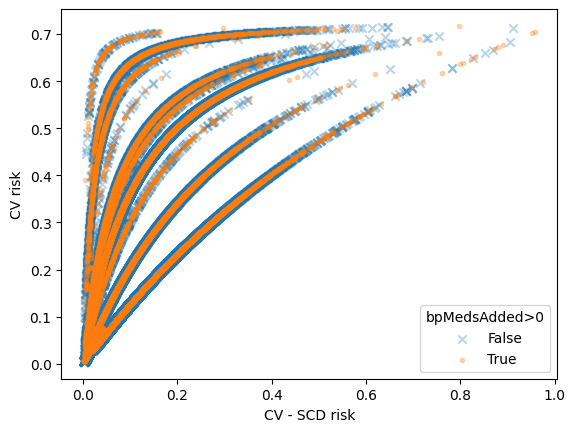

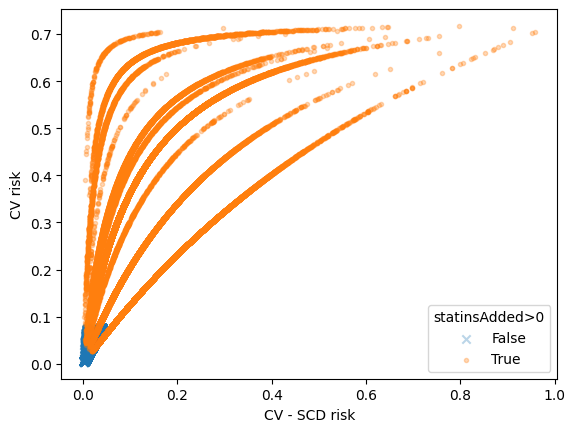

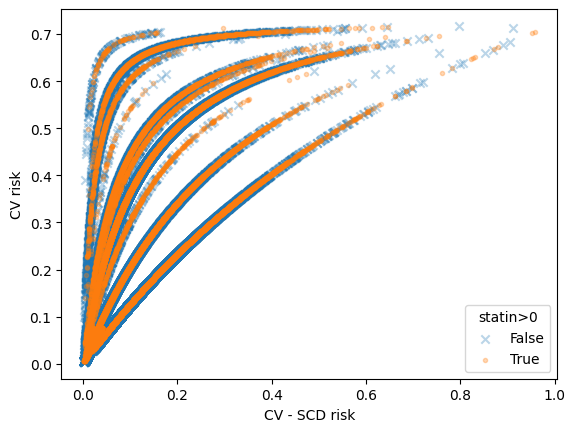

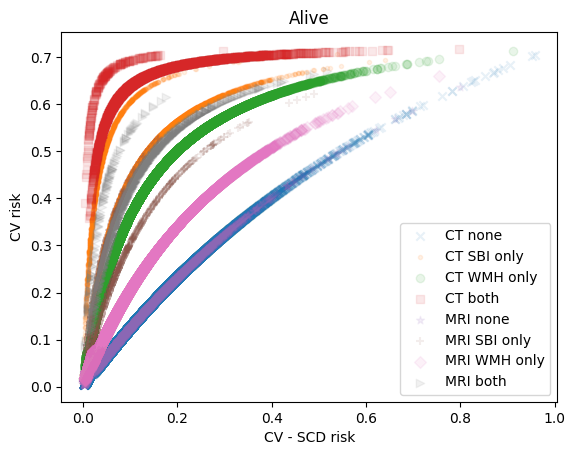

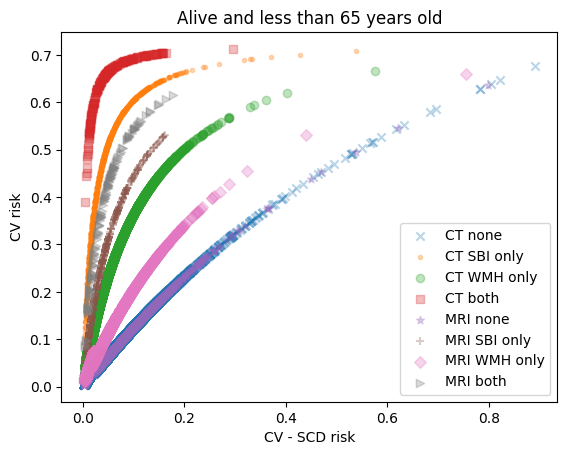

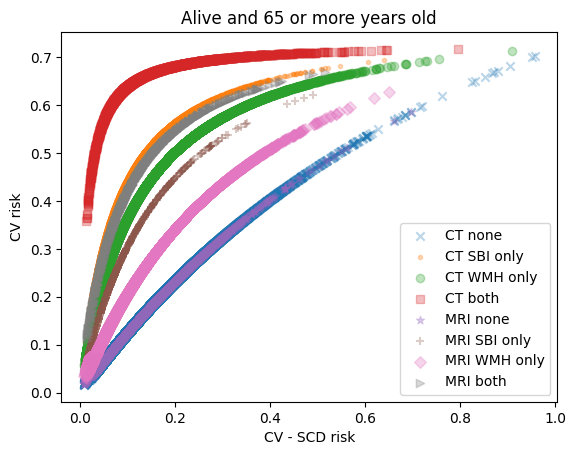

                          -----------------------------------------------------
                          proportion of people in risk bins
                          -----------------------------------------------------
                          CV-SCD risk
                CV risk 0.0-0.1 0.1-0.2 0.2-0.3 0.3-0.4 0.4-0.5 0.5-0.6 0.6-0.7 0.7-0.8 0.8-0.9 0.9-1.0
                0.9-1.0    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 
                0.8-0.9    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 
                0.7-0.8    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 
                0.6-0.7    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 
                0.5-0.6    0.00    0.00    0.02    0.00    0.00    0.00    0.00    0.00    0.00    0.00 
                0.4-0.5    0.00    0.04    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 
        

In [19]:
print_treatment_strategy_higher_order_information(tr.treatedPop)

In [ ]:
pc, np.flip(pc, axis=0)

In [ ]:
pc.sum()

In [ ]:
formatted_string = np.array2string(np.flip(pc, axis=0)/pc.sum(),
                                   precision=2,
                                   suppress_small=True, # Equivalent to suppress=True for array2string
                                   separator=' ',
                                   max_line_width=120)

print("\nUsing np.array2string():")
print(formatted_string)

In [ ]:
print(" "*25, "-"*53)
print(" "*25, "proportion of people in risk bins")
print(" "*25, "-"*53)
risks = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
print(" "*25, "CV-SCD risk")
print(" "*15, "CV risk " + " ".join(risks)) #     0       1       2       3       4 ") 
for i,row in enumerate(np.flip(pc, axis=0)/pc.sum()):
    printString = f"{risks[-i-1]:>23} "
    for item in row:
        printString += f"{item:> 7.2f} " # Format to 2 decimal places, fixed width of 8
    print(printString) # New line after each row
    
print(" "*25, "-"*53)
print(" "*25, "cumulative proportion of people in risk bins")
print(" "*25, "-"*53)
risks = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
print(" "*25, "CV-SCD risk")
print(" "*15, "CV risk " + " ".join(risks)) #     0       1       2       3       4 ") 
for i,row in enumerate(np.flip(pc, axis=0).cumsum(axis=0).cumsum(axis=1)/pc.sum()):
    printString = f"{risks[-i-1]:>23} "
    for item in row:
        printString += f"{item:> 7.2f} " # Format to 2 decimal places, fixed width of 8
    print(printString) # New line after each row

In [ ]:
formatted_string = np.array2string(np.flip(pc, axis=0).cumsum(axis=0).cumsum(axis=1)/pc.sum(),
                                   precision=2,
                                   suppress_small=True, # Equivalent to suppress=True for array2string
                                   separator=' ',
                                   max_line_width=120)

print("\nUsing np.array2string():")
print(formatted_string)

In [ ]:
np.flip(pc, axis=0).cumsum(axis=0).cumsum(axis=1)

In [ ]:
pc.T.cumsum(axis=0).cumsum(axis=1)

In [ ]:
test = np.arange(1,101).reshape(10,10)

In [ ]:
test

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(test, cmap='viridis')
fig.colorbar(cax, label='number of points')
plt.show()

In [ ]:
test.cumsum(axis=0)

In [ ]:
test.cumsum(axis=0).cumsum(axis=1)

In [ ]:
np.fliplr(test.cumsum(axis=0))

In [ ]:
np.fliplr(np.fliplr(test.cumsum(axis=0)).cumsum(axis=1))